# D3D River Module

The following example will familiarize the user with using the D3D toolbox in Mykit-Python. D3d can be used to plot the data from a netCDF output from Delft3d. The example here will show how to plot a contour, or line plot at any desired depth. Along with plotting the raw data. It will also go through how to claulate and plot turbulent intensity. 

Start by importing the necessary python packages and MHKiT module.  

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4

## Loading data from Delft3d as a netCDF 

 A netCDF file has been saved in the [\\MHKiT-Python\\examples\\data\\river\\d3d](https://mhkit-software.github.io/MHKiT/mhkit-python/api.river.html) directory of a simple flume case with a turbine as an example. Here we are saving the data in the netCDF file under the variable "Data."

In [2]:
exdir= dirname(abspath(''))
datadir = normpath(join(exdir,relpath(join('examples','data', 'river', 'd3d'))))
filename= 'turbineTest_map.nc'
data = netCDF4.Dataset(join(datadir,filename))

Getting data from a netcdf file and converting it into a dataframe. First the variables to be pulled from the netCDF file is defined. The vairable 'ucx' is velocity in the x directeion. The full list can be found using "data.variables.keys()" in the consol. The d3d function "get_all_data_points" will pull all the raw data from the netCDF file for the specified variable at a specific time index in a dataframe. -1 automaticaly selects last time_index in the data set and is set to be the defalt. 

In [3]:
variable= 'ucx' 

# All data in  NetCDF File
var_data_df= d3d.get_all_data_points(data, variable, time_index=-1)

## Plotting the Centerline 
The centerline points are found to plot the data. The function "creat_points" creats a grid of points to interploate over with the input of one array and two points, as shown in the example. If you want to plot a location other than the centerline the x,y, and z variables just have to be changed accordingly. z is depth, x is length and y is width all in meters for the flume example.  

In [4]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()

x = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

cline_points = d3d.create_points(x, y, z)

Next the centerline data is interpolated from the Delft3d netcdf file and then plotted.

Text(0.5, 1.0, 'Centerline velocity on flow element center, x-component')

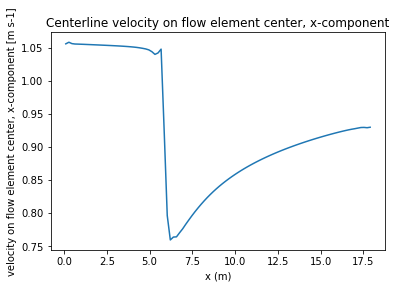

In [13]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']])

Type='Centerline'
plt.plot(x, cline_variable)
plt.xlabel('x (m)')
plt.ylabel(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')
plt.title(f'{Type} {data.variables[variable].long_name}')

## Plotting a Contour Plot

Using the same methiod as the cenerline, a grid of points is created with "d3d.creat_points" with the y input being an array instead of a point. 

In [7]:
y_contour = np.linspace(ymin, ymax, num=40)
contour_points = d3d.create_points(x, y_contour, z) 

Next the data is interpolated on to the points created and added to the contour_points dataframe. 

In [8]:
contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     contour_points[['x','y','z']])
contour_points['contour_variable']= contour_variable

The minimum and maximum values show on the graph are defined by "max_plot_v" and "min_plot_v" respetivly. 

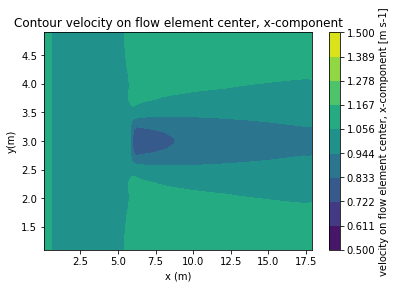

In [9]:
max_plot_v= 1.5
min_plot_v=.5

#Plot contour
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_points.contour_variable,
                               vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y(m)')
plt.title(f'{Type} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')



## Plotting a layer from D3d 

Sometimes it will be useful to plot only the raw data. Using "get_layer_data" a single layer of raw data will be retrived from the netCDF file. 

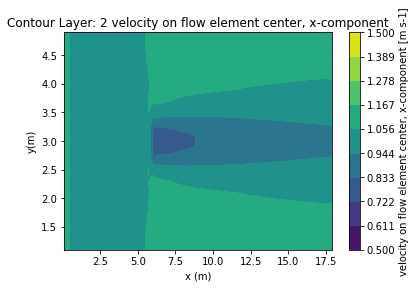

In [15]:
layer=2
[x_layer,y_layer,value_layer] = d3d.get_layer_data(data, variable, layer , time_index=-1)

max_plot_v= 1.5
min_plot_v=.5
  
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(x_layer,y_layer,value_layer, vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y(m)')
plt.title(f'{Type} Layer: {layer} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')
#plt.clim(0,0.08)
plt.savefig(f'contour{layer}.png')
 

## Turbulent Intensity 

Turbulent Intensity is the ratio of the magnitude of turbulent velocity to total velocity. The function "turbulent_intensity" automaticaly pulls variables 'ucx', 'ucy', 'ucz', and 'turkine1' as the velocity in the x, y, z and turbulence respetivly. The function then cauluclates and outputs the turbulent intensity for any given time_index. In this example it is calculating the turbulent intensity ofver the same contour_poits used above however it can also calculat over 'cells', the cooredinate system for the raw velocity data, or 'faces', the coordinate system for the raw turbulence data as well.   

points provided


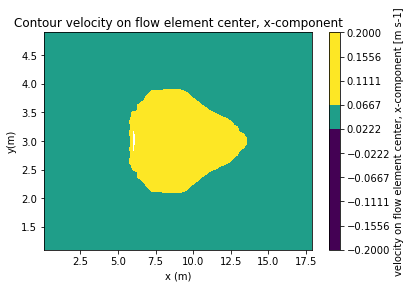

In [12]:
time_index= -1
TI= d3d.turbulent_intensity(data, contour_points,  time_index)
max_plot_v= 0.2
min_plot_v=-0.2
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x, contour_points.y, TI,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y(m)')
plt.title(f'{Type} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')
plt.clim(0,0.08)